In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import numpy as np



def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 {0:.4f}, 정밀도 {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall,f1, roc_auc))
    
    
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df


def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df



titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

# 정밀도/재현율 트레이드 오프

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 : ', pred_proba[:3])

# 예측확률 array와 예측 결과값 array를 병합하여 예측확률과 결과값을 한눈에 확인

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])
print('\n')
# predict가 predict_proba에 기반한 메서드이다.
# predict_proba() 의 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 최종으로 받아서
# 결정하는 것이 predict()

from sklearn.preprocessing import Binarizer

# X=[[1,-1,2],[2,0,0],[0,1.1,1.2]]
# binarizer = Binarizer(threshold=1.1)
# print(binarizer.fit_transform(X))

custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

print('\n')

# 임계값을 낮출수록 positive일 확률이 늘어나므로 정밀도는 떨어지고, 재현율은 올라간다.


thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold)
        custom_predict = binarizer.fit_transform(pred_proba_c1[:,1].reshape(-1,1))
        
        print('임계값 : ', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1[:,1])

get_eval_by_threshold(y_test,pred_proba, thresholds)
print('\n')

# 위의 과정을 실행하는 api
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape : ', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index],2))

print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index],3))
print('\n')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize =(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], ls = '--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])
print('\n')

# 임계값을 임의로 조정하여 정밀도 또는 재현율을 높인다면 좋은 지표가 아닐 수 있다.


# F1스코어
# 2 * (precision*recall)/(precision + recall)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1스코어 : {:.4f}'.format(f1))

thresholds = [0.4,0.45,0.5,0.55,0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)
print('\n')


# roc 커브
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds =  roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1,thresholds.shape[0],5)

print('샘플 추출을 위한 임계값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index],2))

print('샘플 임계값별 FPR : ', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR : ', np.round(tprs[thr_index],3))

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],'k--', label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 -Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

print('\n')





C:\Users\jiyun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

샘플 추출을 위한 임계값 배열의 index 10개 :  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값 :  [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임계값별 FPR :  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임계값별 TPR :  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]




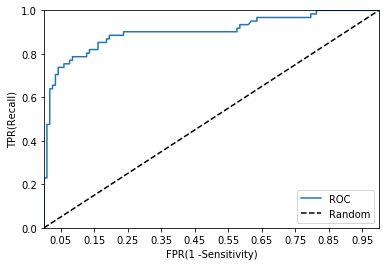

In [9]:
# roc 커브
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds =  roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1,thresholds.shape[0],5)

print('샘플 추출을 위한 임계값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임계값 : ', np.round(thresholds[thr_index],2))

print('샘플 임계값별 FPR : ', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR : ', np.round(tprs[thr_index],3))

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],'k--', label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 -Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba_class1)

print('\n')

